## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from scipy.optimize import curve_fit
from camera_calibration import getCameraCalibrationValues
import os
import glob
import warnings

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Math functions

In [2]:
class Colors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'  # Resets the color to default


In [3]:
def getSobelXGradient(frame):
    sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0)
    return sobelX

def getIntensityIndexOuterEdge(y_values):
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    
    return closest_index

def getIntensityIndexInnerEdge(y_values):
    y_values = -(y_values)
    x_values = np.arange(len(y_values))

    # Define the Gaussian function
    def gaussian(x, amplitude, mean, stddev):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * stddev ** 2))

    # Initial guess for the parameters: amplitude, mean, stddev
    initial_guess = [max(y_values), np.argmax(y_values), 1]

    # Perform the curve fitting
    try:
        params, covariance = curve_fit(gaussian, x_values, y_values, p0=initial_guess, maxfev=10000)
    except RuntimeError as e:
        print(f"{Colors.FAIL}Curve fitting failed: {e}{Colors.ENDC}")
        return np.argmax(y_values)

    # Extract the fitted parameters
    fitted_amplitude, fitted_mean, fitted_stddev = params

    # Find the index closest to the mean
    closest_index = np.argmin(np.round(np.abs(x_values - fitted_mean)))
    
    return closest_index



In [4]:
# Reference Line interpolation

def split_groups_polynomial(values, threshold, degree=3):
    
    high_values = []
    maxReference = np.max(values)
    for i in values:
        if i >= (maxReference - threshold):
            high_values.append(i)
            
    group1 = []
    group2 = []
    high_values_set = set(high_values)
    used_high_values = set()
    
    for value in values:
        if value in high_values_set:
            group1.append(value)
            group2.append(None)
            used_high_values.add(value)
        else:
            group1.append(None)
            group2.append(value)
    
    known_indices = [i for i, x in enumerate(group1) if x is not None]
    known_values = [x for x in group1 if x is not None]
    
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter('always', np.RankWarning)
            
            poly_coeffs = np.polyfit(known_indices, known_values, degree)
            
            if len(w) > 0 and issubclass(w[-1].category, np.RankWarning):
                print("RankWarning: Polyfit may be poorly conditioned")
                # Handle the poorly conditioned case
                return None, group2
            
        poly_interp = np.poly1d(poly_coeffs)
        interp_values = np.round(poly_interp(range(len(group1)))).astype(int)
        
    except Exception as e:
        print(f"An error occurred during polynomial fitting: {e}")
        return None, group2
    
    # poly_interp = np.poly1d(np.polyfit(known_indices, known_values, degree))
    # interp_values = np.round(poly_interp(range(len(group1)))).astype(int)
    
    group1 = [interp_values[i] if x is None else x for i, x in enumerate(group1)]
    
    return group1, group2

In [5]:
# Depth Map for individual frames

def getDepthMap(frame, referenceLine, heightValues):
    depthMap = np.zeros(frame.shape)
    for i in range(frame.shape[0]):
        # print(f"{Colors.OKBLUE}({i}, {referenceLine[i]}, {heightValues[i]})")
        depthMap[i][int(referenceLine[i])] = heightValues[i]
    return depthMap

In [6]:
# Camera Calibration Values
pixels_per_mm, cameraMatrix, dist, rvecs, tvecs = getCameraCalibrationValues()

Chessboard not found
1 mm = 10.627679228349166 pixels
Camera calibrated : 
 0.34352429263843676
Camera Matrix : 
 [[6.29530966e+03 0.00000000e+00 3.31140037e+02]
 [0.00000000e+00 6.36133646e+03 2.73235766e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist : 
 [[ 1.91572262e+01 -6.30755414e+03  2.78251225e-02  1.09198287e-02
  -2.47159800e+01]]
Rotation Vectors : 
 (array([[ 0.13408516],
       [-0.02418959],
       [-0.0025449 ]]), array([[-0.14921689],
       [ 0.07300657],
       [ 0.63636061]]), array([[-0.14169744],
       [ 0.08726113],
       [ 1.24802589]]), array([[-0.13515006],
       [ 0.08980708],
       [ 1.56805538]]), array([[0.12102242],
       [0.02120187],
       [0.46410927]]), array([[ 0.12186551],
       [-0.05546391],
       [ 0.98851071]]), array([[ 0.10437124],
       [-0.10527939],
       [ 1.34445345]]), array([[ 0.10135235],
       [-0.10412304],
       [ 1.49746484]]), array([[-0.13640589],
       [ 0.06773318],
       [ 0.62056035]]), array([[ 0.1136

In [7]:
# Get Point Clouds from Depth Map and Camera Intrinsic Matrix

def getPointClouds(depthMap, cameraIntrinsic):
    height, width = depthMap.shape
    points = []

    fx, fy = cameraIntrinsic[0, 0], cameraIntrinsic[1, 1]
    cx, cy = cameraIntrinsic[0, 2], cameraIntrinsic[1, 2]

    for v in range(height):
        for u in range(width):
            Z = depthMap[v, u]
            if Z == 0:  # Skip invalid depth values
                continue
            X = (u - cx) * Z / fx
            Y = (v - cy) * Z / fy
            points.append([X, Y, Z])

    points = np.array(points)
    # print(f"{Colors.FAIL}Points:{Colors.ENDC}")
    # print(points)
    
    # Create point cloud
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)

    return pcd

## Utilities function

In [8]:
def visualize_depth_map_3d_angle(depth_map, elev=30, azim=30):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, projection='3d')

    x = np.linspace(0, depth_map.shape[1] / 10, depth_map.shape[1])
    y = np.linspace(0, depth_map.shape[0] / 10, depth_map.shape[0])
    x, y = np.meshgrid(x, y)

    ax.plot_surface(x, y, depth_map, cmap='viridis')

    # Create a plane at z = 20 mm
    z_plane = np.full_like(depth_map, 20)
    ax.plot_surface(x, y, z_plane, color='red', alpha=0.5)

    # Add a label on the red plane
    mid_x = (x.max() + x.min()) / 2
    mid_y = (y.max() + y.min()) / 2
    ax.text(mid_x, mid_y, 22, "Height given in CAD design", color='black', fontsize=20, ha='center', va='center')

    ax.set_xlabel('X axis (mm)', fontsize=20)
    ax.set_ylabel('Y axis (mm)', fontsize=20)
    ax.set_zlabel('Depth (mm)', fontsize=20)

    # Increase font size of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='z', which='major', labelsize=16)

    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)

    plt.tight_layout()
    plt.show()

def visualize_depth_map_3d(depth_map):
    fig = plt.figure()
    fig.set_size_inches(10, 10)
    ax = fig.add_subplot(111, projection='3d')

    x = np.linspace(0, depth_map.shape[1] / 10, depth_map.shape[1])
    y = np.linspace(0, depth_map.shape[0] / 10, depth_map.shape[0])
    x, y = np.meshgrid(x, y)

    ax.plot_surface(x, y, depth_map, cmap='viridis')

    ax.set_xlabel('X axis (mm)', fontsize=20)
    ax.set_ylabel('Y axis (mm)', fontsize=20)
    ax.set_zlabel('Depth (mm)', fontsize=20)

    # Increase font size of axis ticks
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='z', which='major', labelsize=16)

    plt.tight_layout()
    plt.show()

In [9]:
## Draw edge trace on the frame

def drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge, intensityOuterEdge, meanIndex, referenceLine, count):
    # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
    edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
    # Convert the grayscale edgeTrace to BGR color image
    edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)
    
    # Define the output folder and create it if it doesn't exist
    output_folder = f'./edge_trace/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

     
    # Plot the intensity points on the edgeTraceColor image
    if intensityInnerEdge is not None:
        for idx, val in enumerate(intensityInnerEdge):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

    if intensityOuterEdge is not None:
        for idx, val in enumerate(intensityOuterEdge):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1
    if meanIndex is not None:
        for idx, val in enumerate(meanIndex):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Yellow dot with radius 1
    if referenceLine is not None:    
        for idx, val in enumerate(referenceLine):
            cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 0), -1)  # Green dot with radius 1

    # Save the image with the plotted points
    cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)

In [10]:
## Draw the depth map for a frame
def drawDepthMapFrame(depthMapFrame, objectName, count):
    output_folder = f'./depth_maps/{objectName}/'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Display the depth map
    cax = ax.imshow(depthMapFrame)
    # Add a color bar
    fig.colorbar(cax, ax=ax)
    # Save the figure
    plt.savefig(f"{output_folder}/frame{count}.jpg")
    # Close the figure to free up memory
    plt.close(fig)

## Experiment

### Video Capture

In [12]:
# # REFERENCE FRAME
# objectName = "reference_03"
# objectFrames = extract_frames(objectName, ".mp4")

# mean_reference = []
# count = 0

# # Loop through the frames
# for frame in objectFrames:
#     # Get the Sobel X gradient
#     # print(f"Processing frame {frame.shape}...")
#     edgeTrace = getSobelXGradient(frame)

#     # Calculate intensity index
#     intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
#     intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
#     meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)
#     # print("Intensity Indices:")
#     # print(intensity)

#     # Convert the Sobel gradient image to absolute values to fit into the 8-bit range
#     edgeTraceAbs = np.abs(edgeTrace).astype(np.uint8)
    
#     # Convert the grayscale edgeTrace to BGR color image
#     edgeTraceColor = cv2.cvtColor(edgeTraceAbs, cv2.COLOR_GRAY2BGR)

#     # Define the output folder and create it if it doesn't exist
#     output_folder = f'./edge_trace/{objectName}/'
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
    
#     # Plot the intensity points on the edgeTraceColor image
#     for idx, val in enumerate(intensityInnerEdge):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (255, 0, 0), -1)  # Blue dot with radius 1

#     for idx, val in enumerate(intensityOuterEdge):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 0, 255), -1)  # Red dot with radius 1

#     for idx, val in enumerate(meanIndex):
#         cv2.circle(edgeTraceColor, (int(val), int(idx)), 1, (0, 255, 255), -1)  # Red dot with radius 1

#     # Save the image with the plotted points
#     cv2.imwrite(f"./edge_trace/{objectName}/frame{count}.jpg", edgeTraceColor)
#     mean_reference.append(abs(np.max(meanIndex) - np.min(meanIndex)))
    
#     count += 1
#     # break  # Remove this break to process all frames

# # mean_reference = np.mean(mean_reference, axis=0)
# # print(f"{Colors.OKGREEN}Mean Reference Indices:{Colors.ENDC}")
# # print(mean_reference)
# print(f"{Colors.OKGREEN}Deva of Reference Indices:{Colors.ENDC}")
# print(mean_reference)

### Snapshots at measured steps

In [13]:
#REFERENCE LINE

objectName = "05.08.24.Reference_Scan"

meanPixelDisplacement = []
count = 0

heightList = []

# Define the translation distance between frames in mm
translation_distance = 0.75

objectFrames = glob.glob(f"./measured_steps/{objectName}/*.jpg")


referenceLineList = []
# Loop through the frames
for image in objectFrames:
    print(f"Processing frame {image}...")
    frame = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    
    # Get the Sobel X gradient
    edgeTrace = getSobelXGradient(frame)
    # Calculate intensity index along the laser edge trace
    intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
    intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
    meanIndex = np.round((intensityInnerEdge + intensityOuterEdge) / 2)

    # maxIntensity = np.argmax(edgeTrace, axis=1)

    
    referenceLine = meanIndex
    # referenceLine = maxIntensity
    
   
    drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge, intensityOuterEdge, meanIndex, referenceLine, count)
    # drawEdgeTrace(objectName, edgeTrace, None, None, None, None, count)
    
    referenceLineList.append(referenceLine)

    count += 1
    # break  # Remove this break to process all frames

Processing frame ./measured_steps/05.08.24.Reference_Scan\StillSnapshot000065.jpg...


In [14]:
referenceLineList = np.array(referenceLineList)
referenceLineList.shape

(1, 480)

In [16]:
referenceLine[-1]

330.0

In [17]:
#OBJECT HEIGHT MEASUREMENT

# Define the object name and extract frames
objectName = "test1"

meanPixelDisplacement = []
count = 0

heightList = []
all_point_clouds = []

objectFrames = glob.glob(f"./measured_steps/{objectName}/*.jpg")

depthMap = []

# Loop through the frames
for image in objectFrames:
    print(f"Processing frame {image}...")
    frame = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    cv2.imwrite(f"./edge_trace/{objectName}/gray_{count}.jpg", frame)
    
    # Get the Sobel X gradient
    edgeTrace = getSobelXGradient(frame)

    edgeMax = np.max(edgeTrace, axis=1)

    c = pixels_per_mm
    referenceLine = referenceLineList[count]

    if np.any(edgeMax < 30):
        print(f"{Colors.FAIL}No edge detected in frame {count}{Colors.ENDC}")
        heights = depthMap[-1]
        depthMap.append(heights)
        drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge=None, intensityOuterEdge=None, meanIndex=None, referenceLine=None, count=count)
        count += 1
        continue      

    # Calculate intensity index along the laser edge trace
    intensityInnerEdge = np.round(np.array([getIntensityIndexInnerEdge(i) for i in edgeTrace]))
    intensityOuterEdge = np.round(np.array([getIntensityIndexOuterEdge(i) for i in edgeTrace]))
    meanIndex = np.zeros(len(intensityInnerEdge))
    for i in range(len(intensityInnerEdge)):
        if abs(intensityInnerEdge[i] - intensityOuterEdge[i]) > 30:
            print(f"{Colors.FAIL}No edge detected in frame {count}{Colors.ENDC}")
            meanIndex[i] = referenceLine[i]
        else:
            meanIndex[i] = np.round((intensityInnerEdge[i] + intensityOuterEdge[i]) / 2)
            if meanIndex[i] > referenceLine[i]:
                meanIndex[i] = referenceLine[i]

   
    drawEdgeTrace(objectName, edgeTrace, intensityInnerEdge, intensityOuterEdge, meanIndex, referenceLine, count)
    
    if referenceLine is None:
        print(f"{Colors.FAIL}Reference line not found{Colors.ENDC}")
        heights = depthMap[-1]
        referenceLine = referenceLineList[-1]
    else:
        pixelDisplacement = abs(meanIndex - referenceLine)
        c = pixels_per_mm
        s = pixelDisplacement / c
        heights = 80 * s / (37.3 + s)

    depthMap.append(heights)

    # Depth map for individual frames
    depthMapFrame = getDepthMap(frame, referenceLine, heights)
    drawDepthMapFrame(depthMapFrame, objectName, count)

    count += 1
    # break  # Remove this break to process all frames

Processing frame ./measured_steps/test1\StillSnapshot000174.jpg...


In [15]:
depthMapCopy = np.array(depthMap)
depthMapCopy.shape

(65, 480)

In [16]:
np.savetxt("output.csv", depthMapCopy, delimiter=",")

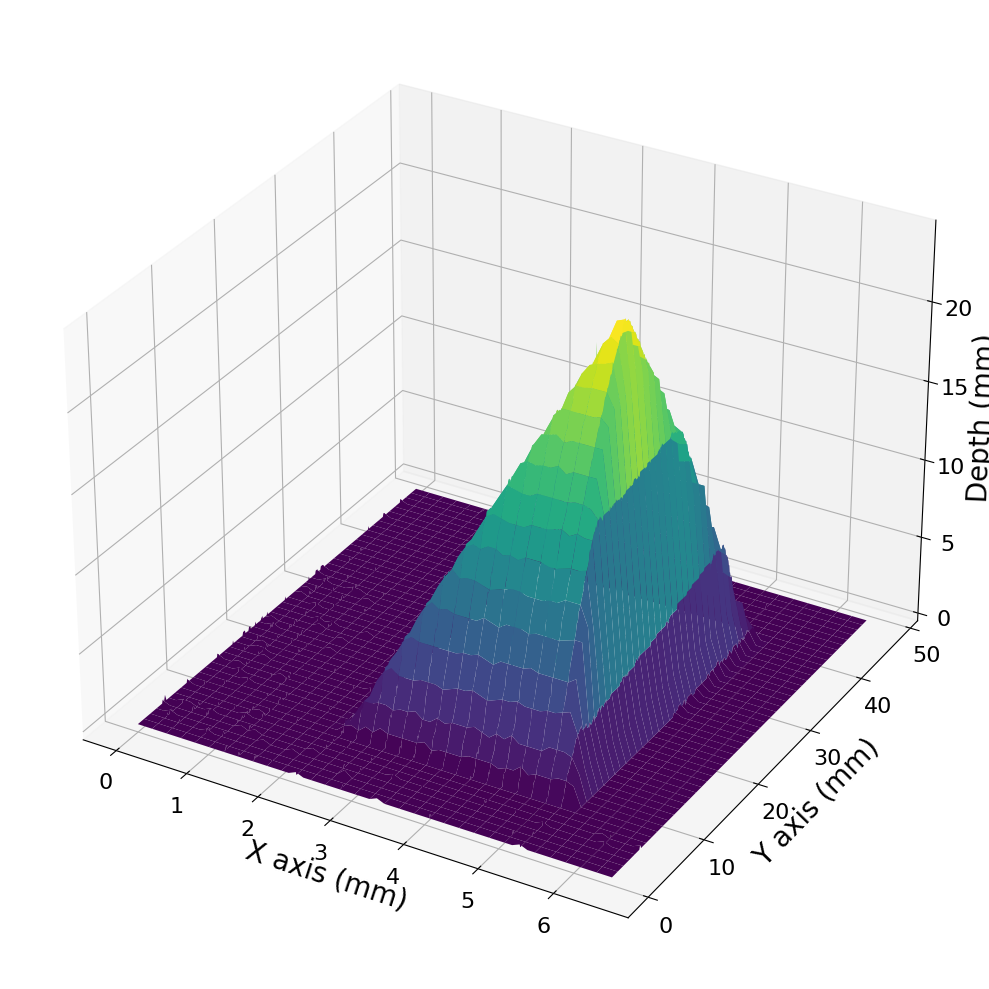

In [17]:
visualize_depth_map_3d(depthMapCopy.T) 
visualize_depth_map_3d_angle(depthMapCopy, elev=0, azim=120)  # Change viewing angle

In [19]:
depthMapCopy = depthMap.copy()
depthMapCopy = depthMapCopy[1:]
# test = depthMap.copy()[-1]
# depthMapCopy.append(test)
# print(test)

(64, 480)


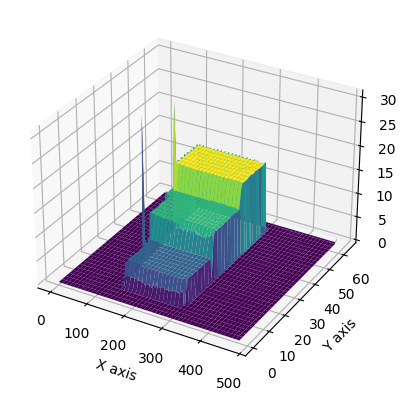

In [20]:
depthMapCopy = np.array(depthMapCopy)
print(depthMapCopy.shape)
visualize_depth_map_3d(depthMapCopy)

In [91]:
len(depthMapCopy)

64

In [29]:
# dFrame = np.zeros((480, 640))
dFrame = []
for i in range(len(depthMapCopy)):
    for j in range(i, i+10):
        if j < len(depthMapCopy[0]):
            dFrame.append(depthMapCopy[i])
        else:
            print("Breaking at", j)
            break

In [30]:
dFrame = np.array(dFrame)
dFrame.shape

(640, 480)

In [26]:
dFrame = np.array(dFrame)
dFrame = dFrame.T
print(dFrame.shape)

(480, 640)


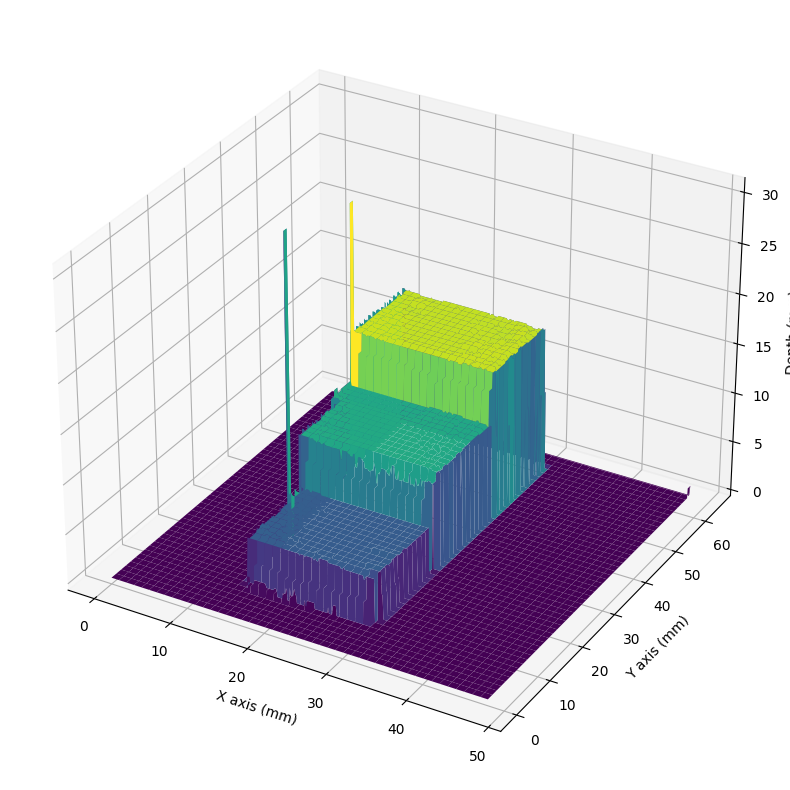

In [35]:
# visualize_depth_map_3d(dFrame[:, 25:60])
visualize_depth_map_3d(dFrame[:, :])

In [89]:
frame = cv2.imread("./1mmblackcube/Reference/Snap_113.jpg", cv2.IMREAD_GRAYSCALE)
pcd = getPointClouds(dFrame, cameraMatrix)
# Visualize point cloud
o3d.visualization.draw_geometries([pcd])

In [90]:
# Compute normals for the combined point cloud
print("Computing normals for the combined point cloud...")
combined_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Perform surface reconstruction using Poisson reconstruction
print("Performing surface reconstruction...")
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(combined_pcd, depth=9)

# Optionally, remove low-density vertices to clean up the mesh
vertices_to_remove = densities < np.quantile(densities, 0.01)
mesh.remove_vertices_by_mask(vertices_to_remove)

# Save and visualize the mesh
mesh_folder = f'./meshes/'
if not os.path.exists(mesh_folder):
    os.makedirs(mesh_folder)
o3d.io.write_triangle_mesh(f'{mesh_folder}/{objectName}.ply', mesh)
o3d.visualization.draw_geometries([mesh])

Computing normals for the combined point cloud...


NameError: name 'combined_pcd' is not defined

In [6]:
def min_execution_time(n, high_priority, normal_time, priority_time):
    # Convert high_priority indices to a set for O(1) lookups
    high_priority_set = set(high_priority)
    
    # DP table initialization
    dp = [[float('inf')] * n for _ in range(n)]
    
    # Function to calculate execution time for a given subarray
    def calculate_time(l, r):
        high_priority_count = sum(1 for i in range(l + 1, r + 2) if i in high_priority_set)
        total_processes = r - l + 1
        if high_priority_count == 0:
            return normal_time
        else:
            return priority_time * high_priority_count * total_processes
    
    # Fill the DP table for subarrays of size 1
    for i in range(n):
        dp[i][i] = calculate_time(i, i)
    
    # Fill the DP table for larger subarrays
    for length in range(2, n + 1):  # subarray lengths from 2 to n
        for l in range(n - length + 1):
            r = l + length - 1
            dp[l][r] = calculate_time(l, r)
            if (r - l + 1) % 2 == 0:  # if the subarray length is even
                mid = (l + r) // 2
                dp[l][r] = min(dp[l][r], dp[l][mid] + dp[mid + 1][r])
    
    # The answer for the full array is in dp[0][n-1]
    print(dp)
    return dp[0][n-1]

# Example Usage
n = 4
high_priority = [1]
normal_time = 2
priority_time = 2
print(min_execution_time(n, high_priority, normal_time, priority_time))  # Expected output: 12


[[2, 4, 6, 6], [inf, 2, 2, 2], [inf, inf, 2, 2], [inf, inf, inf, 2]]
6


In [8]:
n = 4096
normal_time =918
priority_time = 918
high_priority = [123,1823,3434,2732,744,204,2928,2884,263,721,1641,1407,3974,1595,3372,423,4,3117,1730,3414,2968,3164,1259,509,3400,914,1689,2911,3219,555,2674,3603,2024,2715,338,3589,3884,4069,199,1269,3640,1061,1427,2294,1881,1800,1582,753,3535,1103,1346,1312,78,592,1069,403,896,116,1410,174,3200,1466,3976,1961,2912,3891,3769,3855,1444,3716,2117,2367,197,2151,3213,2286,3248,810,2472,1955,3652,1326,3553,3130,2519,873,2614,354,3506,1243,3103,3216,2111,2997,584,2083,1064,1760,266,2959,1000,2858,867,1517,3798,3221,2216,1226,481,217,2815,3749,3594,479,1510,3444,1767,71,3242,2336,290,1507,241,516,248,2106,2353,2930,2235,2822,1846,1872,694,3744,2801,1714,1773,2914,1255,2669,1281,2116,3121,3620,636,1378,100,1035,3999,3756,777,877,2522,612,539,1831,3669,652,3115,3179,1235,2752,4095,2089,1590,3343,3899,3284,1118,1039,3936,2739,1065,1210,249,3569,532,382,679,2221,1541,513,952,533,523,1864,2270,2737,3512,3151,3362,3717,1330,1220,1381,2441,1970,3978,1755,2359,3467,971,270,3733,720,2366,2114,3876,987,1868,2090,3991,2094,1842,2277,3155,2082,289,3235,3059,866,1725,3627,454,1902,3486,3926,79,1561,2514,1937,3012,3084,2137,607,1857,3541,466,3464,3111,2333,988,773,1715,755,1716,176,797,2091,3222,2771,553,2160,1936,1679,1383,1369,3709,4083,73,374,3859,2030,3714,3685,2574,711,2798,1149,2076,16,1917,1495,1911,4013,3526,3555,3984,3960,1718,2439,2156,512,267,410,2341,264,2010,1386,6,2313,1335,3030,3253,1068,2883,1870,3470,1129,1395,2263,2526,3504,125,2727,3765,530,1497,2634,3737,2100,1976,3871,3073,2513,891,220,565,1081,3590,2055,3266,1342,634,2521,879,1158,3559,1179,3396,1350,2641,2056,3295,656,723,3826,250,2255,3358,2242,727,3341,771,1706,2301,927,2710,1572,2988,1218,2696,310,1456,2832,3863,2001,2553,1762,491,200,3885,1430,3138,3746,194,1915,1390,538,1413,2646,341,3229,1556,993,3824,719,868,3142,1740,3846,3387,2444,973,2230,1434,3683,1733,421,416,2362,2730,1991,795,3704,126,2543,1225,2681,940,2946,2349,3659,1396,3033,483,560,193,3608,2080,3572,2317,3791,3767,2199,380,548,2978,4058,9,2217,2853,3331,3136,2903,1669,1505,1931,287,1646,2093,3780,2144,1776,446,2736,2325,2806,2122,474,2872,2984,1263,2652,1437,3889,1514,648,3858,3561,402,3384,2836,1525,335,3763,941,3675,1088,1564,1234,1696,313,1151,4088,2528,990,1670,4047,307,428,2733,580,511,2386,2957,3241,1385,3757,3301,5,2409,2190,134,2962,1866,2873,1237,3903,2604,742,845,3630,3834,311,2965,2289,766,2404,1022,1539,271,627,2690,4087,1367,3052,2027,2579,2743,4042,1711,3029,3438,2999,177,579,3337,881,3020,2421,76,1805,1099,2842,1965,2418,1903,3316,4056,1756,3565,3927,2905,1645,2990,309,2383,12,758,4084,3273,469,1117,821,251,2896,3597,1675,3641,2329,1680,3227,3225,935,1131,3338,3755,3268,167,2236,2644,3570,386,212,3152,3811,1320,82,2788,3300,2941,3821,1108,3335,1769,2510,2358,3815,2596,2203,2368,1705,1454,1623,2141,2506,3451,151,299,1433,885,1540,1918,504,1244,2779,2724,1620,2302,36,2895,84,984,928,638,641,1141,2171,3202,4078,1092,3310,90,526,3831,3374,803,2881,1603,3167,2986,1058,1206,2135,3797,3644,2818,371,4059,2908,709,10,3441,3759,2948,2201,3247,863,1021,2647,2155,842,2749,2666,1167,2436,1193,3697,3223,889,1787,535,2607,3128,2867,1867,3489,294,1287,1878,545,3772,2554,3312,3799,3311,2032,737,2797,1893,2437,702,2440,2061,1331,4034,3269,1360,3409,3104,214,4039,2956,890,2688,1217,1890,192,3240,4092,924,508,517,2610,2556,2782,3957,3711,1222,1357,334,326,30,3959,3877,1139,207,50,2654,17,2713,2258,4062,792,1550,3203,4041,1532,3803,849,4085,3,3487,3422,3693,3530,624,353,1007,1985,2850,1647,2218,2559,1054,586,3947,2868,3336,1196,3433,482,3112,3278,1301,865,1681,1020,1307,3365,1067,1144,2110,2266,1586,1013,979,3807,3509,3612,2246,536,3850,1421,982,1938,3536,3521,905,1778,1038,3272,1185,59,717,2491,3067,2523,2919,3050,2124,3946,3735,3804,497,2445,4006,3599,305,2575,161,2676,1182,3401,1707,1639,4001,850,415,2113,3390,2686,1545,3056,3061,362,373,1876,564,1207,2918,3157,3800,3437,2563,1174,1834,2759]

print(min_execution_time(n, high_priority, normal_time, priority_time)) 

In [4]:
from collections import defaultdict, deque

def getNumPairs(server_nodes, server_from, server_to, server_weight, signal_speed):
    # Step 1: Build the tree as an adjacency list
    tree = defaultdict(list)
    for u, v, w in zip(server_from, server_to, server_weight):
        tree[u].append((v, w))
        tree[v].append((u, w))
    
    def bfs(start):
        # Initialize distances from start node to all other nodes
        distances = [-1] * (server_nodes + 1)
        distances[start] = 0
        queue = deque([start])
        
        while queue:
            u = queue.popleft()
            for v, w in tree[u]:
                if distances[v] == -1:  # If not visited
                    distances[v] = distances[u] + w
                    queue.append(v)
        return distances
    
    result = [0] * server_nodes
    
    for i in range(1, server_nodes + 1):
        distances = bfs(i)
        # Collect all nodes where distance from i is divisible by signal_speed
        valid_nodes = [d for d in distances if d % signal_speed == 0 and d != 0]
        count = len(valid_nodes)
        # Calculate the number of valid pairs (j, k) with both valid
        result[i - 1] = count 
    
    return result

# Example usage
server_nodes = 4
server_from = [1, 1, 2]
server_to = [2, 3, 4]
server_weight = [2, 5, 3]
signal_speed = 5

print(getNumPairs(server_nodes, server_from, server_to, server_weight, signal_speed))  # Expected output: [2, 0, 2, 2]


[2, 0, 2, 2]
